<a href="https://colab.research.google.com/github/eTcilopp/geek_brains/blob/main/43_data_science_libs/hw07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 7
## Сравнение работы алгоритмов деревьев решений. Использование ансамблевых алгоритмов
1. Загрузка и предварительный анализ данных:
Загрузите данные из предоставленного файла fetch_california_housing.xlsx.
Исследуйте структуру данных, проведите описательный анализ основных статистических показателей.

2. Предобработка данных:
Очистите данные от возможных аномалий и пропущенных значений.

3. Построение моделей:
— Разделите данные на обучающую и тестовую выборки.
— Постройте и обучите модели RandomForestRegressor и GradientBoostingRegressor.
— Постарайтесь оптимизировать их гиперпараметры для улучшения результатов на обучающей выборке.
5. Анализ важности признаков и выводы:
— Используйте атрибут feature_importances_ для оценки важности признаков в каждой модели.
— На основе полученных данных сделайте выводы о том, какие признаки наиболее значимы и почему.

6. Дополнительные задачи (для желающих углубить знания):
— Проведите кросс-валидацию результатов.
— Исследуйте влияние удаления некоторых признаков на производительность моделей.

4. Оценка моделей:
— Оцените качество моделей на тестовой выборке с использованием метрик RMSE (Root Mean Squared Error) и R² (коэффициент детерминации).
— Сравните результаты моделей, интерпретиру

In [6]:
!pip install bayesian-optimization -q

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from bayes_opt import BayesianOptimization

# Загрузка данных

In [3]:
data = pd.read_excel('https://gbcdn.mrgcdn.ru/uploads/asset/6088861/attachment/dfd3d20e6a4977068f4cfadc49034b3e.xlsx')

# EDA

In [4]:
data.shape

(20640, 9)

In [5]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41,6.984127,1.023810,322,2.555556,37.88,-122.23,4.526
1,8.3014,21,6.238137,0.971880,2401,2.109842,37.86,-122.22,3.585
2,7.2574,52,8.288136,1.073446,496,2.802260,37.85,-122.24,3.521
3,5.6431,52,5.817352,1.073059,558,2.547945,37.85,-122.25,3.413
4,3.8462,52,6.281853,1.081081,565,2.181467,37.85,-122.25,3.422


In [8]:
data.isna().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
target,0


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
target,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


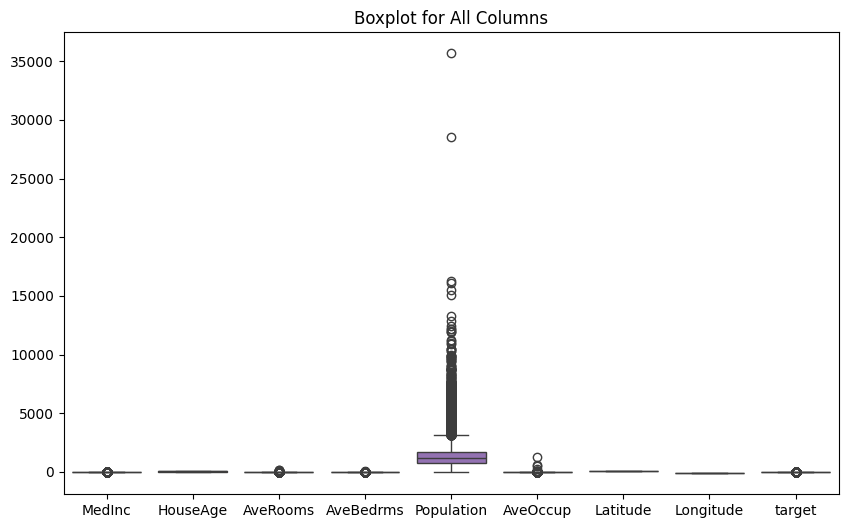

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)

plt.title("Boxplot for All Columns")
plt.show()

Наблюдаем выбросы по населенности,<br>
Построим "ящики" без нее

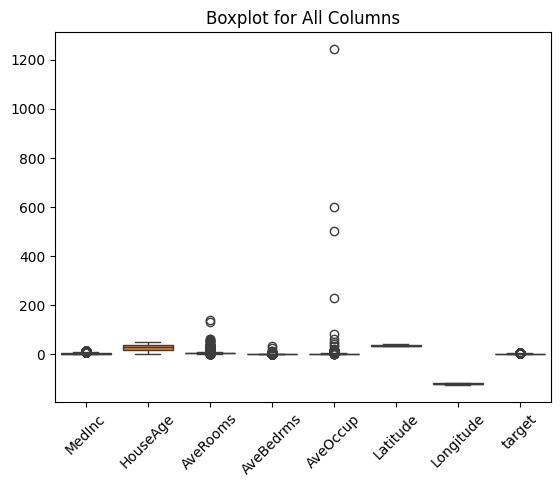

In [11]:
sns.boxplot(data=data.drop('Population', axis=1))
plt.xticks(rotation=45)
plt.title("Boxplot for All Columns")
plt.show()

Тепловая карта корреляции - не дает ничего особенного

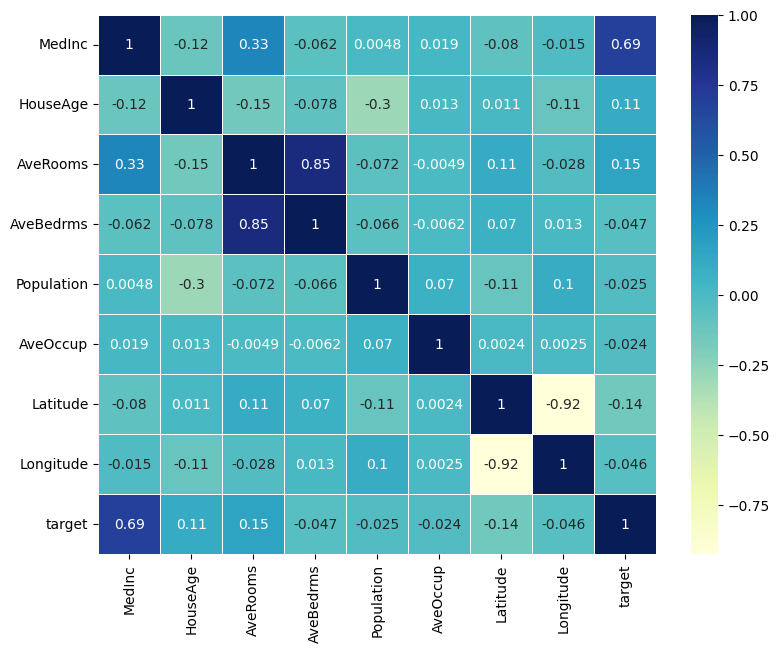

In [12]:
df_corr = data.corr(method='pearson', min_periods=1)

# Задаем размер фигуры для визуализации
plt.figure(figsize=(9, 7))

# Создаем тепловую карту корреляции
sns.heatmap(df_corr,
            xticklabels=df_corr.columns,
            yticklabels=df_corr.columns,
            annot=True,
            linewidths=0.5,
            cmap="YlGnBu");

Разобъем датасет на тренировочную и тестовую части

In [13]:
X = data.drop(columns=['target'])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(
    f"Размер X_train: {len(X_train)}; "
    f"Размер X_test: {len(X_test)}\n"
    f"Размер y_train: {len(y_train)}; "
    f"Размер y_test: {len(y_test)}"
)

Размер X_train: 16512; Размер X_test: 4128
Размер y_train: 16512; Размер y_test: 4128


In [14]:
def random_forest_cross_validation(**kwargs):
    n_estimators = int(kwargs.get('n_estimators'))
    max_depth = None if int(kwargs.get('max_depth')) == 0 else int(kwargs.get('max_depth'))
    min_samples_split = int(kwargs.get('min_samples_split'))
    min_samples_leaf = int(kwargs.get('min_samples_leaf'))
    max_features = float(kwargs.get('max_features'))

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )


    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring='neg_mean_squared_error',
        cv=5
    )

    return scores.mean()

In [15]:
param_bounds = {
    'n_estimators': (100, 300),
    'max_depth': (0, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'max_features': (0.1, 1.0)
}

In [16]:
optimizer = BayesianOptimization(
    f=random_forest_cross_validation,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

In [17]:
optimizer.maximize(init_points=10, n_iter=30)
best_params_rf = optimizer.max['params']

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -0.2775   | 11.24     | 0.9556    | 3.196     | 6.789     | 131.2     |
| 2         | -0.7559   | 4.68      | 0.1523    | 3.599     | 6.809     | 241.6     |
| 3         | -0.2606   | 0.6175    | 0.9729    | 3.497     | 3.699     | 136.4     |
| 4         | -0.4907   | 5.502     | 0.3738    | 2.574     | 5.456     | 158.2     |
| 5         | -0.2938   | 18.36     | 0.2255    | 1.876     | 4.931     | 191.2     |
| 6         | -0.2538   | 23.56     | 0.2797    | 2.543     | 6.739     | 109.3     |
| 7         | -0.2528   | 18.23     | 0.2535    | 1.195     | 9.591     | 293.1     |
| 8         | -0.2505   | 24.25     | 0.3742    | 1.293     | 7.474     | 188.0     |
| 9         | -0.5883   | 3.661     | 0.5457    | 1.103     | 9.275     | 151.8     |
| 10        | -0.2495   | 19.88     | 0.3805    | 2.56

In [20]:
best_params_rf['n_estimators'] = int(best_params_rf['n_estimators'])
best_params_rf['max_depth'] = None if best_params_rf['max_depth'] == 0 else int(best_params_rf['max_depth'])
best_params_rf['min_samples_split'] = int(best_params_rf['min_samples_split'])
best_params_rf['min_samples_leaf'] = int(best_params_rf['min_samples_leaf'])
best_params_rf['max_features'] = float(best_params_rf['max_features'])

In [21]:
best_model_rf = RandomForestRegressor(
    **best_params_rf,
    random_state=42,
    n_jobs=-1
)
best_model_rf.fit(X_train, y_train)
best_train_preds_rf = best_model_rf.predict(X_train)

best_train_mse_rf = mean_squared_error(y_train, best_train_preds_rf)

best_train_rmse_rf = np.sqrt(best_train_mse_rf)

In [22]:
print(f"Лучшие параметры RandomForestRegressor: {best_params_rf}")
print(f"RMSE на обучающей выборке с лучшими параметрами: {best_train_rmse_rf:.2f}")

Лучшие параметры RandomForestRegressor: {'max_depth': None, 'max_features': 0.33782290313616253, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 299}
RMSE на обучающей выборке с лучшими параметрами: 0.18


# Выводы:
<br>
max_depth: None
<br>
глубина деревьев не ограничена. Модель может строить деревья до тех пор, пока все листья не будут чистыми или пока не будут выполнены другие ограничения
<br>
<br>
max_features: 0.3378
<br>
Модель использует около 33.8% признаков при каждом разбиении узла.<br>
Это ограничивает модель, что помогает избежать переобучения и делает работу деревьев более разнообразной.
<br>
<br>
min_samples_leaf: 1
<br>
Каждый лист дерева может содержать хотя бы одну обучающую точку.
<br>
<br>
min_samples_split: 2
<br>
Узел будет разделен, если в нем есть как минимум 2 выборки
<br>
<br>
n_estimators: 299
<br>
Модель использует 299 деревьев. Такое количество деревьев обеспечивает стабильность модели, так как увеличивает разнообразие деревьев в ансамбле.
<br>
<br>
RMSE на обучающей выборке: 0.18
<br>
Это низкое значение RMSE, которое говорит о том, что модель точно предсказывает целевые значения на тренировочных данных.<br>
Низкое значение RMSE может быть результатом переобучения


# Анализ важности признаков

In [23]:
importances = best_model_rf.feature_importances_
print(importances)

[0.36214738 0.05652324 0.11666976 0.04431439 0.03550271 0.12328682
 0.132535   0.12902071]


In [24]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,MedInc,0.362147
6,Latitude,0.132535
7,Longitude,0.129021
5,AveOccup,0.123287
2,AveRooms,0.116670
1,HouseAge,0.056523
3,AveBedrms,0.044314
4,Population,0.035503


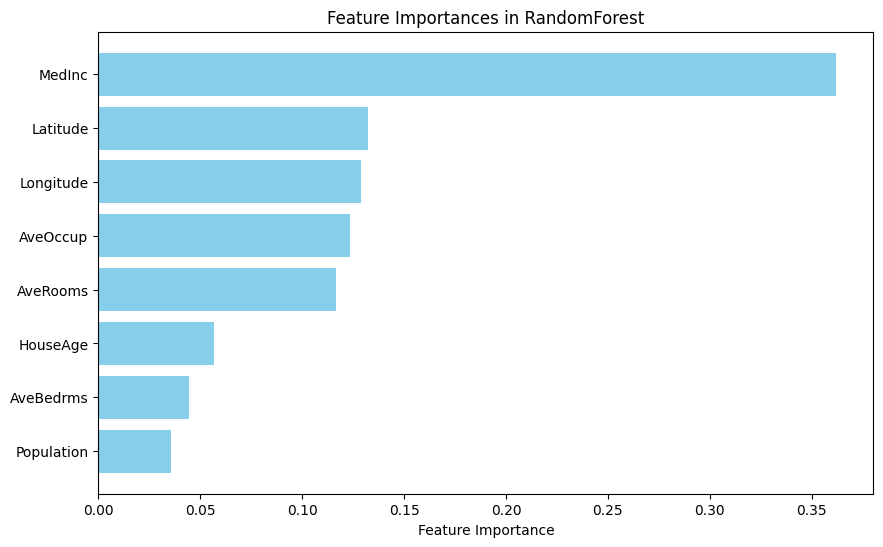

In [25]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in RandomForest')
plt.gca().invert_yaxis()
plt.show()

Самым важным признаком является средний доход (MedInc)

# GradientBoostingRegressor

In [26]:
def gradient_boosting_regression_cross_validation(**kwargs):
    n_estimators = int(kwargs.get('n_estimators'))
    max_depth = None if int(kwargs.get('max_depth')) == 0 else int(kwargs.get('max_depth'))
    min_samples_split = int(kwargs.get('min_samples_split'))
    min_samples_leaf = int(kwargs.get('min_samples_leaf'))
    max_features = float(kwargs.get('max_features'))

    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )


    scores = cross_val_score(
        model,
        X_train,
        y_train,
        scoring='neg_mean_squared_error',
        cv=5
    )

    return scores.mean()

In [29]:
param_bounds = {
    'n_estimators': (100, 300),
    'max_depth': (1, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'max_features': (0.1, 1.0)
}

In [30]:
optimizer = BayesianOptimization(
    f=gradient_boosting_regression_cross_validation,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

In [31]:
optimizer.maximize(init_points=10, n_iter=30)
best_params_gb = optimizer.max['params']

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -0.2337   | 11.86     | 0.9556    | 3.196     | 6.789     | 131.2     |
| 2         | -0.2552   | 5.524     | 0.1523    | 3.599     | 6.809     | 241.6     |
| 3         | -0.4355   | 1.597     | 0.9729    | 3.497     | 3.699     | 136.4     |
| 4         | -0.2295   | 6.319     | 0.3738    | 2.574     | 5.456     | 158.2     |
| 5         | -0.278    | 18.74     | 0.2255    | 1.876     | 4.931     | 191.2     |
| 6         | -0.2449   | 23.77     | 0.2797    | 2.543     | 6.739     | 109.3     |
| 7         | -0.2383   | 18.62     | 0.2535    | 1.195     | 9.591     | 293.1     |
| 8         | -0.2484   | 24.44     | 0.3742    | 1.293     | 7.474     | 188.0     |
| 9         | -0.2453   | 4.539     | 0.5457    | 1.103     | 9.275     | 151.8     |
| 10        | -0.2436   | 20.21     | 0.3805    | 2.56

In [32]:
best_params_gb['n_estimators'] = int(best_params_gb['n_estimators'])
best_params_gb['max_depth'] = int(best_params_gb['max_depth'])
best_params_gb['min_samples_split'] = int(best_params_gb['min_samples_split'])
best_params_gb['min_samples_leaf'] = int(best_params_gb['min_samples_leaf'])
best_params_gb['max_features'] = float(best_params_gb['max_features'])

In [33]:
best_model_gb = RandomForestRegressor(
    **best_params_gb,
    random_state=42,
    n_jobs=-1
)
best_model_gb.fit(X_train, y_train)
best_train_preds_gb = best_model_gb.predict(X_train)

best_train_mse_gb = mean_squared_error(y_train, best_train_preds_gb)

best_train_rmse_gb = np.sqrt(best_train_mse_gb)

In [39]:
print(f"Лучшие параметры GradientBoostingRegressor: {best_params_gb}")
print(f"RMSE на обучающей выборке с лучшими параметрами: {best_train_rmse_gb:.2f}")

Лучшие параметры GradientBoostingRegressor: {'max_depth': 6, 'max_features': 0.6616325294687148, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 218}
RMSE на обучающей выборке с лучшими параметрами: 0.60


# Выводы
Был выполнен подбор гиперпараметров GradientBoostingRegressor, и наилучшие значения найдены для ключевых параметров:
<br>
max_depth = 6 — глубокие деревья могут захватывать сложные зависимости в данных.
<br>
max_features = 0.66 — модель использует примерно две трети признаков для построения каждого дерева, что помогает снизить переобучение.
<br>
min_samples_leaf = 1 и min_samples_split = 2 — настройки позволяют максимально разделять данные, подходящие для хорошо сбалансированных выборок.
<br>
n_estimators = 218 — достаточно большое число деревьев для устойчивого обучения без сильного переобучения.
<br><br>
Качество на обучающей выборке очень хорошее:
<br>
RMSE = 0.60. Это говорит о том, что предсказания модели на обучающих данных в среднем на 0.60 единиц отклоняются от реальных значени - достаточно хороший результат

# Анализ важности признаков

In [35]:
importances = best_model_gb.feature_importances_
print(importances)

[0.62953342 0.04075031 0.08201369 0.00999826 0.00308886 0.13423541
 0.05950066 0.04087938]


In [36]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,MedInc,0.629533
5,AveOccup,0.134235
2,AveRooms,0.082014
6,Latitude,0.059501
7,Longitude,0.040879
1,HouseAge,0.040750
3,AveBedrms,0.009998
4,Population,0.003089


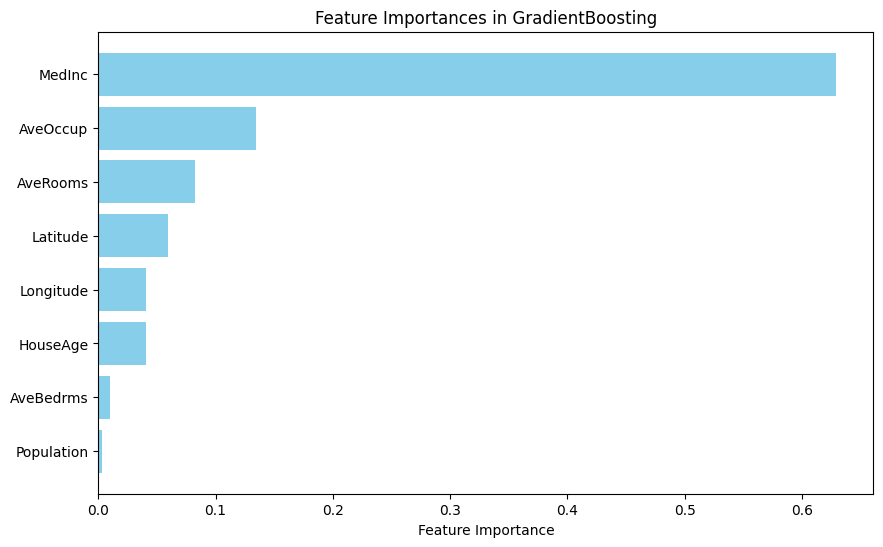

In [38]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in GradientBoosting')
plt.gca().invert_yaxis()
plt.show()

И опять с большим отрывом - главным признаком является средний доход (medInc)